<H1 style="text-align: center">ECMM422 - Machine Learning</H1>
<H2 style="text-align: center">Assignment 2: Ensemble Methods</H2>



| <font style="font-size:larger;">Date set     | <font style="font-size:larger;">Hand-in date |
|:------------------|:-----------------------------------|
|<font style="font-size:larger;"> 12th February 2020 |<font style="font-size:larger;">**  12 noon, Wednesday 19th February 2020 ** |

</font>

Candidate number:  <font color="red">*660022200*</font>

Marking is anonymous, so please don't write your name or reveal your identity!

This assigment will count for 25% of the module mark.  

Your report should consist of your IPython notebook showing what you did, what was the
result, and what you can conclude from the exercise. Each report will be
assessed on the following criteria:

* Does it record what was done in the exercise?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

### Submitting the notebooks

Note that an electronic submission is required.  You should also submit the notebook electronically at [electronic hand-in system]( http://empslocal.ex.ac.uk/submit/).  You just need to submit the single .ipynb file that is the notebook, so you should be able to upload it directly from the directory where you have saved it on a University machine or your laptop.  If you're not sure where in your homespace it is, type <code>pwd</code> (print working directory) in a cell to find out where the notebooks are.

<b>Note: you must also submit your cover sheet and E-Submit receipt via BART to complete the submission.</b>


<div class="alert alert-info">
 Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 
 </div>

In [1]:
%pylab inline
figsize(15, 10)

# for matrices and numerical methods
import numpy as np

# for plotting functions
import matplotlib.pyplot as plt

# for loading the data we will use
from sklearn import datasets, tree

# for KFold cross-validation
from sklearn.model_selection import KFold,train_test_split

# for calculating accuracy, check help(accuracy_score) for details
from sklearn.metrics import accuracy_score

# for having progress bars for longer processes, use help(tqdm) for syntax
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
from time import time
tics = []
def tic(): 
    tics.append(time())
def toc(): 
    if tics: 
        return time() - tics.pop()
    else: 
        return None

# Ensemble learning 

In this workshop you will investigate how ensemble of trees perform on a classification task and the importance of the parameters. We will use a digit classification task as an example. 
This will be done in the following stages: 

1. Training a tree on the data and evaluating the bias and variance of the model, using N-fold cross validation. 
2. Comparing performance with a random forest, evaluating the effect of tree depth and forest size
3. Build a boosted collection of trees and evaluate the performance. 

At each stage you should test your code and check the results


### Data: The digits dataset

For this CA you should use the <i>digits</i> data available in <tt>sklearn</tt> as an example (see below).

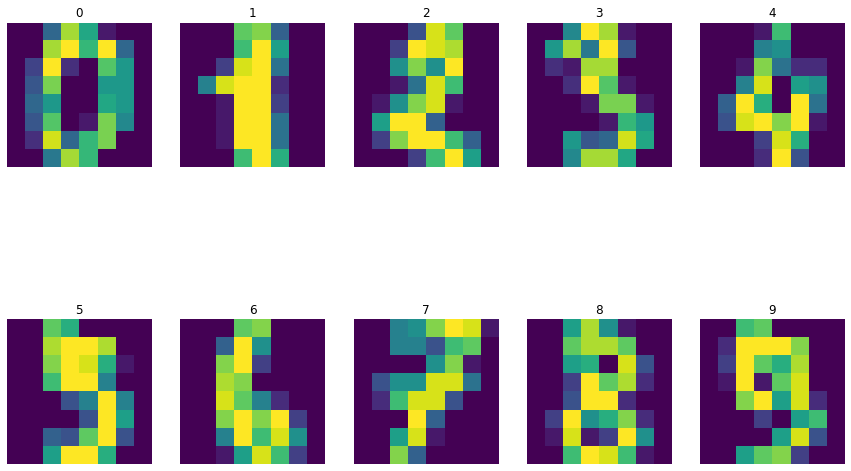

In [3]:
# loading the digit data
(X,Y) = datasets.load_digits(return_X_y=True)

# let's display some examples (the first 10 digits in the dataset)
figure()
for i in range(10): 
    subplot(2,5,i+1)
    imshow(X[i,:].reshape((8,8)))
    title('{}'.format(i))
    axis('off')

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size=0.25)
    
kfold = KFold(n_splits=5)    # 5 fold CV here.

### Decision Tree

In this part you are asked to train a decision tree on the digits data. You should use the implementation of the classification tree in sklearn, which allows you to play with the parameters (read the documentation). Read especially on the <i>max_depth</i>, <i>min_samples_split</i> and <i>min_samples_leaf</i> parameters. 
* Draw a graph of the mean and variance of the classification accuracy depending on tree depth - use N-fold cross validation to get these estimates.
<div style="text-align: right"><b>[15 marks]</b></div>
* Calculate the confusion matrix for the tree with the best performance. 

<div style="text-align: right"><b>[10 marks]</b></div>


Function for plotting the confusion matrix, taken from 
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [4]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<ErrorbarContainer object of 3 artists>

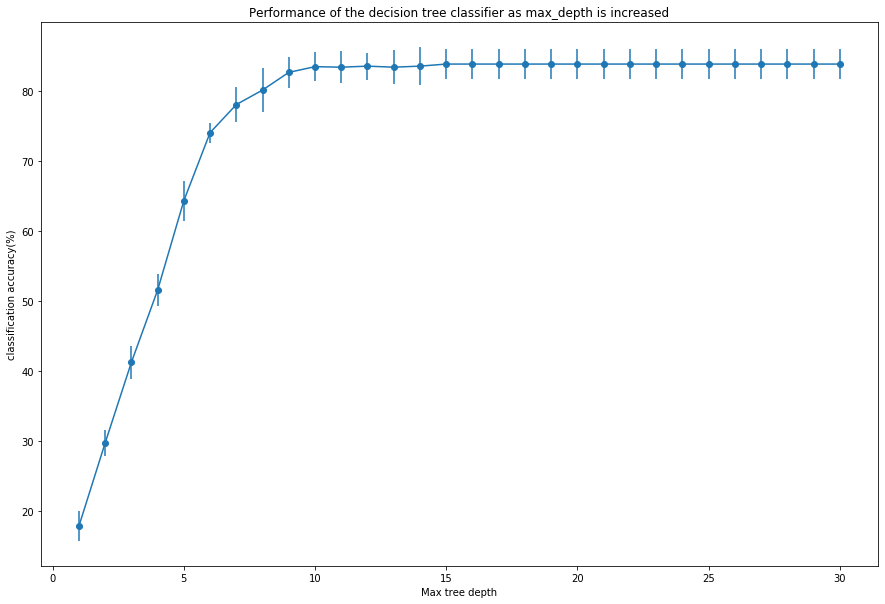

In [5]:
from sklearn.tree import DecisionTreeClassifier
def find_errdtc(Xtrain,Ytrain,dvals,folds): 
    v_err_vec = np.zeros((1,len(dvals)))  #initialises validation score vector
    v_err_var = np.zeros((1,len(dvals)))  #initialises standard deviation vector
    for i in dvals:
        dtc = DecisionTreeClassifier(max_depth = i, random_state = 42)  
        kf = KFold(n_splits=folds, shuffle=True, random_state = 42) #sets up the kfold with 'folds' splits
        v_err = np.zeros((folds,1))
        c = 0
        for train, validation in kf.split(Xtrain):
            dtc.fit(Xtrain[train], Ytrain[train])  #We fit a classifier based on our training data for each fold
            v_err[c,:] = accuracy_score(dtc.predict(Xtrain[validation]),Ytrain[validation])  #validation scores stored for each fold
            c = c + 1  #count
        
        v_err_vec[0,i-1] = np.sum(100*v_err)  #the total validation score is stored in a vector; with position based on the depth value
        v_err_var[0,i-1] = np.std(100*v_err)  #stores the standard deviation for each value
    
    avv_err = v_err_vec/folds  #turns total score vector into average score vector
    matr = np.stack((avv_err[0,:],v_err_var[0,:]), axis=0) #stacks the vectors to output
    return matr

dvals = np.arange(30) + 1
out = find_errdtc(Xtrain,Ytrain,dvals,5)
plt.figure()
plt.title('Performance of the decision tree classifier as max_depth is increased') 
plt.xlabel('Max tree depth')
plt.ylabel('classification accuracy(%)')
errorbar(x = dvals, y = out[0,:], yerr = out[1,:], fmt = '-o')


We observe the performance of our classifier improves massively as the max tree depth is increased from 1 as the majority of the data is able to be classified within the first 4-8 layers of the decision tree at which the plateau occurs.

The performance then reaches a plateau at which the classifier stops adding more layers, where the actual tree depth plateaus at a value of roughly 12-14 (depending on randomness of Kfold) even though the max tree depth is increased. This is because all final nodes in the tree have become pure(gini index = 0) and all of the data belongs to a single class within each final node. Actual tree depth found using dtc.tree_.max_depth 

We observe the standard deviation more or less stays consistent and the same on the plateau as the model has used the same tree depth on the plateau as previously mentioned.

We also generally observe a very small peak at around max tree depth 10-14 indicating a small amount of overfitting for tree depths larger than 10. Hence forth we choose that as our optimal max tree depth to prevent overfitting.

Text(0, 0.5, 'Variance')

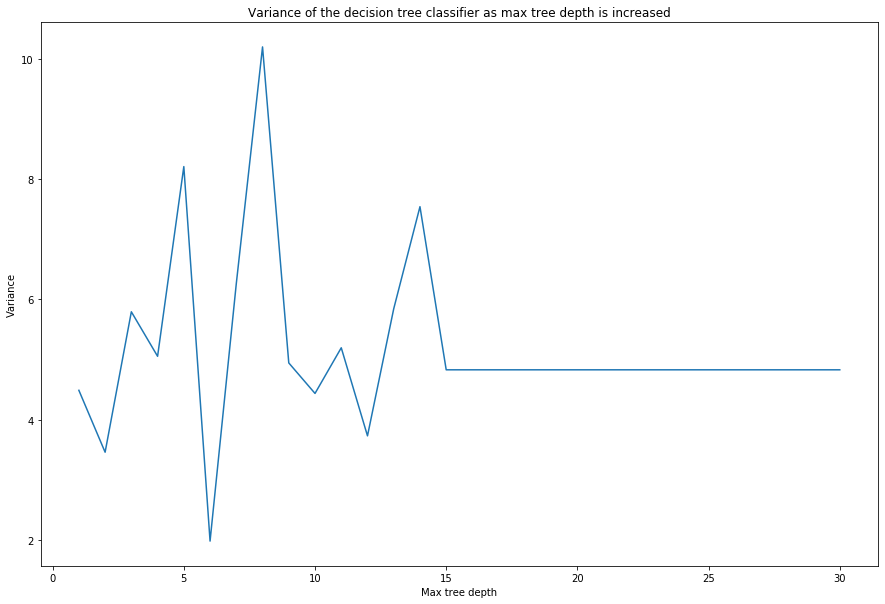

In [6]:
plt.figure()
plt.plot(dvals,out[1,:]**2)
plt.title('Variance of the decision tree classifier as max tree depth is increased') 
plt.xlabel('Max tree depth')
plt.ylabel('Variance')

The Variance is erratic and generally spikes up and down . We usually see a decrease in this behaviour and then the variance hits a constant as both the classifier and kfold have seeds in them so the variance will be the same as we are using the same tree depth where the variance is constant. This allows me to see how the tree depth directly affects the classification accuracy without any extra random behaviour occurring.

If we get rid of the seed in our classifier we observe the same behaviour with smaller spikes where the horizontal line is which would then be produced by the randomness in the classifier. 

The test score for our decision tree classifier is 82.44444444444444
Confusion matrix, without normalization
[[40  0  0  0  0  1  0  0  0  0]
 [ 0 42  5  0  1  0  1  1  2  2]
 [ 1  2 36  1  0  2  0  1  0  0]
 [ 0  0  1 37  0  1  1  1  3  3]
 [ 1  1  1  0 32  1  1  1  1  1]
 [ 1  1  0  2  1 45  3  0  1  3]
 [ 1  2  0  0  0  0 47  2  0  0]
 [ 0  0  1  2  1  1  1 30  0  1]
 [ 1  1  2  3  0  0  1  0 26  3]
 [ 1  1  1  0  0  1  0  1  1 36]]


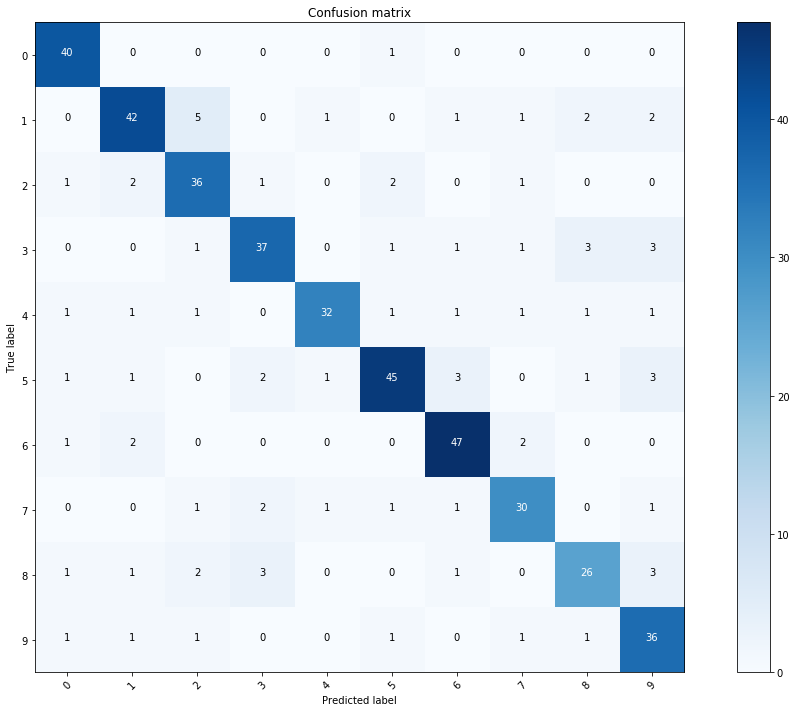

In [7]:
from sklearn.metrics import confusion_matrix
r = np.where(out[0,:] == np.amax(out[0,:])) #taking the depth with the best classification accuracy
check = r[0]  #location of maximum score
dtc = DecisionTreeClassifier(max_depth = dvals[check[0]])
tic()
dtc.fit(Xtrain,Ytrain)  #refits using all the training data and the best parameter
dtctime = toc()
dtctesterr = 100*accuracy_score(dtc.predict(Xtest),Ytest)
print("The test score for our decision tree classifier is",dtctesterr)
ptest = dtc.predict(Xtest)  
cm = confusion_matrix(Ytest, ptest)
plot_confusion_matrix(cm, np.unique(Ytest))

### Random Forests
In this part, you are asked to use Random Forest using sklearn trees as weak learners. You will use the function provided by sklearn: <tt> sklearn.ensemble.RandomForestClassifier</tt>. 

100%|██████████| 40/40 [00:46<00:00,  1.17s/it]


<ErrorbarContainer object of 3 artists>

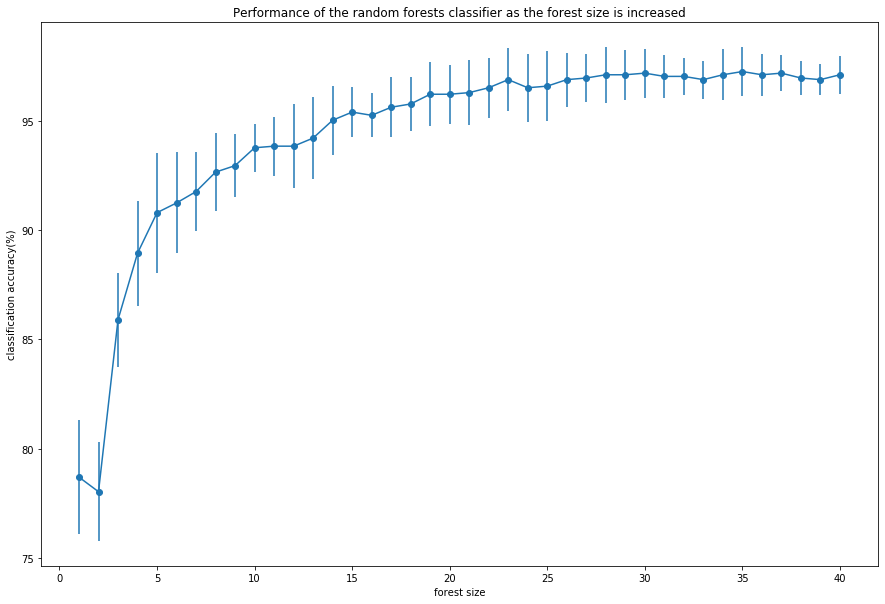

In [8]:
from sklearn.ensemble import RandomForestClassifier
def find_err_forsize(Xtrain,Ytrain,fsvals,treedepth,folds): 
    v_err_vec = np.zeros((1,len(fsvals)))  #initialises validation score vector
    v_err_var = np.zeros((1,len(fsvals)))  #initialises standard deviation vector
    for i in tqdm(fsvals):
        rfc = RandomForestClassifier(n_estimators=i, max_depth=treedepth, n_jobs=-1, random_state = 42) #insert random_state=0 for consistent output 
        kf = KFold(n_splits=folds, shuffle=True, random_state = 42) #sets up the kfold with 'folds' splits
        v_err = np.zeros((folds,1))
        c = 0
        for train, validation in kf.split(Xtrain):
            rfc.fit(Xtrain[train], Ytrain[train])  #We fit a classifier based on our training data for each fold
            v_err[c,:] = accuracy_score(rfc.predict(Xtrain[validation]),Ytrain[validation])  #validation scores stored for each fold
            c = c + 1  #count
        
        v_err_vec[0,i-1] = np.sum(100*v_err)  #the total validation score is stored in a vector; with position based on the depth value
        v_err_var[0,i-1] = np.std(100*v_err)  #standard deviations across kfold for each forest size value
    
    avv_err = v_err_vec/folds  #turns total score vector into average score vector
    matr = np.stack((avv_err[0,:],v_err_var[0,:]), axis=0) #stacks the vectors to output
    return matr

fsvals = np.arange(40) + 1
out = find_err_forsize(Xtrain,Ytrain,fsvals,10,5)
plt.figure()
plt.title('Performance of the random forests classifier as the forest size is increased') 
plt.xlabel('forest size')
plt.ylabel('classification accuracy(%)')
errorbar(x = fsvals, y = out[0,:], yerr = out[1,:], fmt = '-o')

Again we observe a sharp increase in performance of the Random Forests Classifier as forest size if increased from 1. This then reaches a plateau as the forest size is increased to 40.

Generally we observe a slight decrease in the standard deviation of our classification accuracy as forest size is increased. This is because the bagging is averaging over 'forest size' classifications thereby reducing the overall prediction standard deviation.

<ErrorbarContainer object of 3 artists>

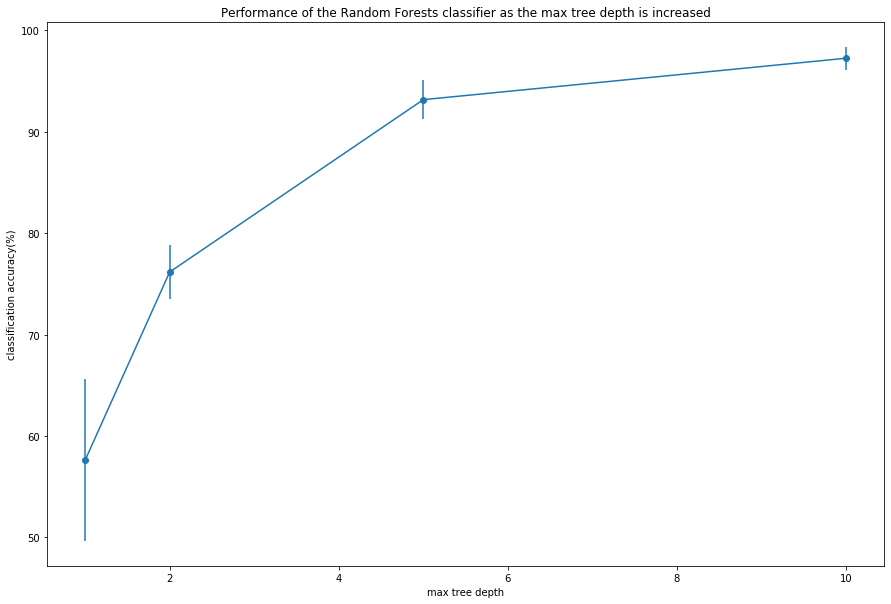

In [9]:
r = np.where(out[0,:] == np.amax(out[0,:])) #taking the depth with the best classification accuracy
check = r[0]  #location of maximum score
bestfs = fsvals[check[0]]

def find_err_tdepth(Xtrain,Ytrain,tdvals,bestfs,folds): 
    v_err_vec = np.zeros((1,len(tdvals)))  #initialises validation score vector
    v_err_var = np.zeros((1,len(tdvals)))  #initialises variance vector
    for i in np.arange(len(tdvals)):
        rfc = RandomForestClassifier(n_estimators=bestfs, max_depth=tdvals[i], n_jobs=-1, random_state = 42) #insert random_state=0 for consistent output 
        kf = KFold(n_splits=folds, shuffle=True, random_state = 42) #sets up the kfold with 'folds' splits
        v_err = np.zeros((folds,1))
        c = 0
        for train, validation in kf.split(Xtrain):
            rfc.fit(Xtrain[train], Ytrain[train])  #We fit a classifier based on our training data for each fold
            v_err[c,:] = accuracy_score(rfc.predict(Xtrain[validation]),Ytrain[validation])  #validation scores stored for each fold
            c = c + 1  #count
        
        v_err_vec[0,i] = np.sum(100*v_err)  #the total validation score is stored in a vector; with position based on the depth value
        v_err_var[0,i] = np.std(100*v_err)  #standard deviations across kfold for each tree depth value
    
    avv_err = v_err_vec/folds  #turns total score vector into average score vector
    matr = np.stack((avv_err[0,:],v_err_var[0,:]), axis=0) #stacks the vectors to output
    return matr

tdvals = [1,2,5,10]
outalt = find_err_tdepth(Xtrain,Ytrain,tdvals,bestfs,5)
plt.figure()
plt.title('Performance of the Random Forests classifier as the max tree depth is increased') 
plt.xlabel('max tree depth')
plt.ylabel('classification accuracy(%)')
errorbar(x = tdvals, y = outalt[0,:], yerr = outalt[1,:], fmt = '-o')


Choosing the best forest size value from the previous graph(the forest size value that produces the highest classification accuracy) I run the classification model for max tree depths: 1,2,5, and 10. We observe an increase in performance as the max tree depth increases similar to the decision tree classifier(dtc) performance graph from earlier. We also see the model start to plateau in this graph aswell. This is because the majority of the data is able to be classified within the first 3-6 layers of the decision tree.

We also observe a decrease in the standard deviation as the max tree depth is increased as before when considering the dtc performance graph previously. This is because we find the performance across the folds is more consistent for higher tree depths. 

100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


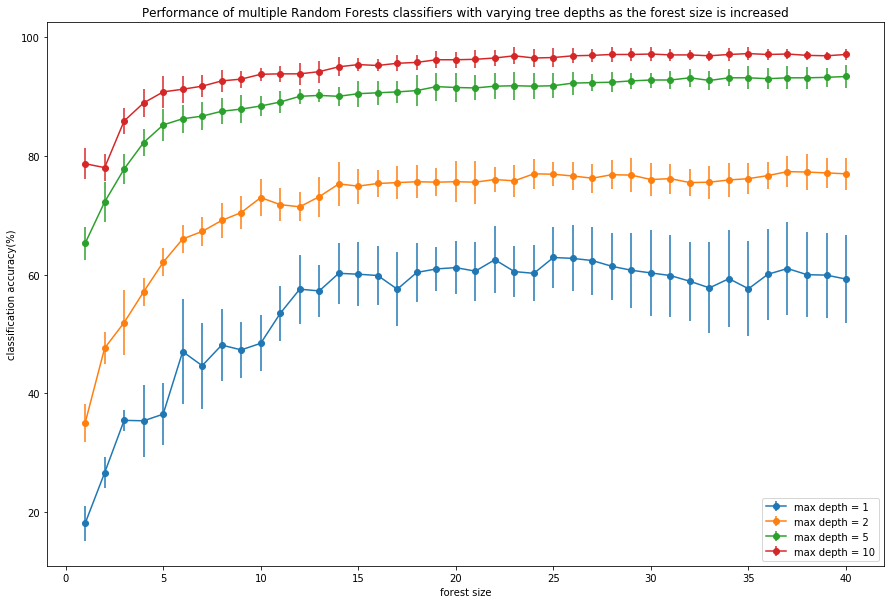

In [10]:
fsvals = np.arange(40) + 1
out1 = find_err_forsize(Xtrain,Ytrain,fsvals,1,5)
plt.figure()
errorbar(x = fsvals, y = out1[0,:], yerr = out1[1,:], label = 'max depth = 1', fmt = '-o')

out2 = find_err_forsize(Xtrain,Ytrain,fsvals,2,5)
errorbar(x = fsvals, y = out2[0,:], yerr = out2[1,:], label = 'max depth = 2', fmt = '-o')

out5 = find_err_forsize(Xtrain,Ytrain,fsvals,5,5) 
errorbar(x = fsvals, y = out5[0,:], yerr = out5[1,:], label = 'max depth = 5', fmt = '-o')

out10 = find_err_forsize(Xtrain,Ytrain,fsvals,10,5) 
errorbar(x = fsvals, y = out10[0,:], yerr = out10[1,:], label = 'max depth = 10', fmt = '-o')

plt.title('Performance of multiple Random Forests classifiers with varying tree depths as the forest size is increased') 
plt.xlabel('forest size')
plt.ylabel('classification accuracy(%)')
plt.legend(loc = 'lower right')

In this graph we see how the classification accuracy varies as we increase the forest size for each max tree depth: 1,2,5 and 10. As expected we find the standard deviations are larger for smaller max depths. 
We see that the lines more or less follow the same pattern: a gradual increase followed by a plateau as expected.
We also see the best performance occur for max tree depth 10 which is expected following from our previous graphs.

The test score for our random forests classifier is 96.0
Confusion matrix, without normalization
[[41  0  0  0  0  0  0  0  0  0]
 [ 0 54  0  0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0]
 [ 1  0  0 43  0  1  0  0  1  1]
 [ 0  0  0  0 37  0  0  1  1  1]
 [ 0  0  0  0  1 55  1  0  0  0]
 [ 0  0  0  0  1  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 37  0  0]
 [ 0  1  3  1  0  0  0  1 31  0]
 [ 0  0  0  0  0  1  0  0  1 40]]


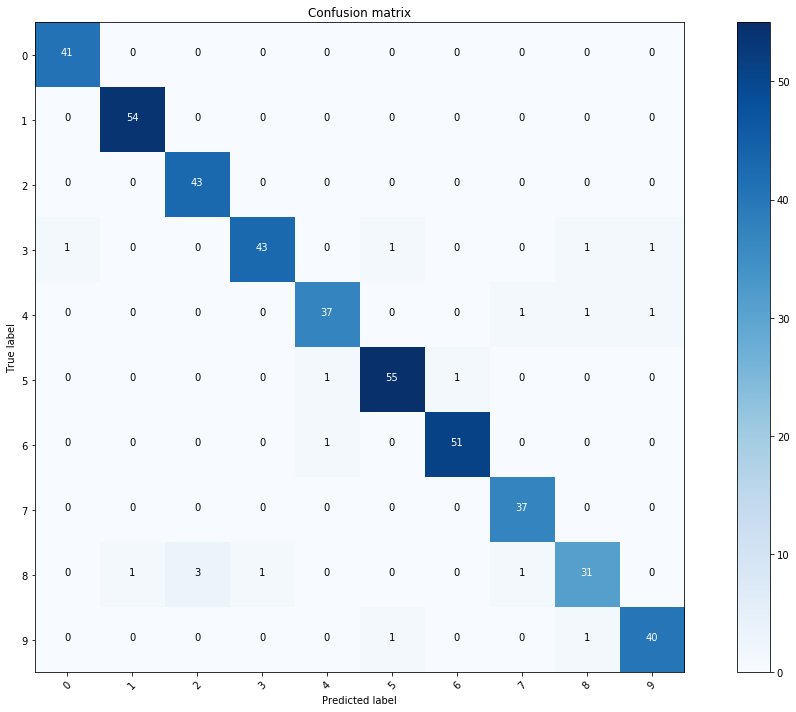

In [11]:
r = np.where(outalt[0,:] == np.amax(outalt[0,:])) #taking the depth with the best classification accuracy
check = r[0]  #location of maximum score
besttd = tdvals[check[0]]

rfc = RandomForestClassifier(n_estimators=bestfs, max_depth=besttd, n_jobs=-1)
tic()
rfc.fit(Xtrain,Ytrain)
rfctime = toc()

rfctesterr = 100*accuracy_score(rfc.predict(Xtest),Ytest)
print("The test score for our random forests classifier is",rfctesterr)

ptest = rfc.predict(Xtest)  
cm = confusion_matrix(Ytest, ptest)
plot_confusion_matrix(cm, np.unique(Ytest))

Once you have coded this, provide a graph of the accuracy curves for different <b>tree depths</b> and <b>forest size</b>: 
* The first graph with the forest size as the $x$-axis, classification error as the $y$-axis.
<div style="text-align: right"><b>[10 marks]</b></div>
* The second graph with tree depth (eg, for 1,2,5 and 10) as the $x$-axis, classification error as the $y$-axis.
<div style="text-align: right"><b>[10 marks]</b></div>
* Again, use N-Fold cross-validation to plot <b>error bars</b> on your graphs. 
<div style="text-align: right"><b>[10 marks]</b></div>
* As before, provide the <b>confusion matrix</b> for the forest with best performance. 
<div style="text-align: right"><b>[10 marks]</b></div>

### Boosting
In this last section you are asked to use AdaBooost using sklearn tree stumps (trees with a <b>single non-leaf node</b>) as weak learners. You will use the function provided by sklearn: <tt>sklearn.ensemble.AdaBoostClassifier</tt>
which supports multiclass problems. 

Once you have done this, plot a similar curve as you did before, with boosting rounds as $x$-axis, classification error as $y$-axis and one curve for tree depth of 1,2,5 and 10, using N-Fold cross-validation to obtain error bars.
<div style="text-align: right"><b>[20 marks]</b></div>

In [12]:
from sklearn.ensemble import AdaBoostClassifier
def find_err_bsrounds(Xtrain,Ytrain,bsvals,treedepth,folds): 
    v_err_vec = np.zeros((1,len(bsvals)))  #initialises validation score vector
    v_err_var = np.zeros((1,len(bsvals)))  #initialises standard deviation vector
    for i in tqdm(bsvals):
        abc = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=treedepth), n_estimators=i, random_state = 42) 
        kf = KFold(n_splits=folds, shuffle=True, random_state = 42) #sets up the kfold with 'folds' splits
        v_err = np.zeros((folds,1))
        c = 0
        for train, validation in kf.split(Xtrain):
            abc.fit(Xtrain[train], Ytrain[train])  #We fit a classifier based on our training data for each fold
            v_err[c,:] = accuracy_score(abc.predict(Xtrain[validation]),Ytrain[validation])  #validation scores stored for each fold
            c = c + 1  #count
        
        v_err_vec[0,i-1] = np.sum(100*v_err)  #the total validation score is stored in a vector; with position based on the depth value
        v_err_var[0,i-1] = np.std(100*v_err)  #standard deviations across kfold for each boosting rounds value
    
    avv_err = v_err_vec/folds  #turns total score vector into average score vector
    matr = np.stack((avv_err[0,:],v_err_var[0,:]), axis=0) #stacks the vectors to output
    return matr



100%|██████████| 40/40 [01:21<00:00,  2.04s/it]


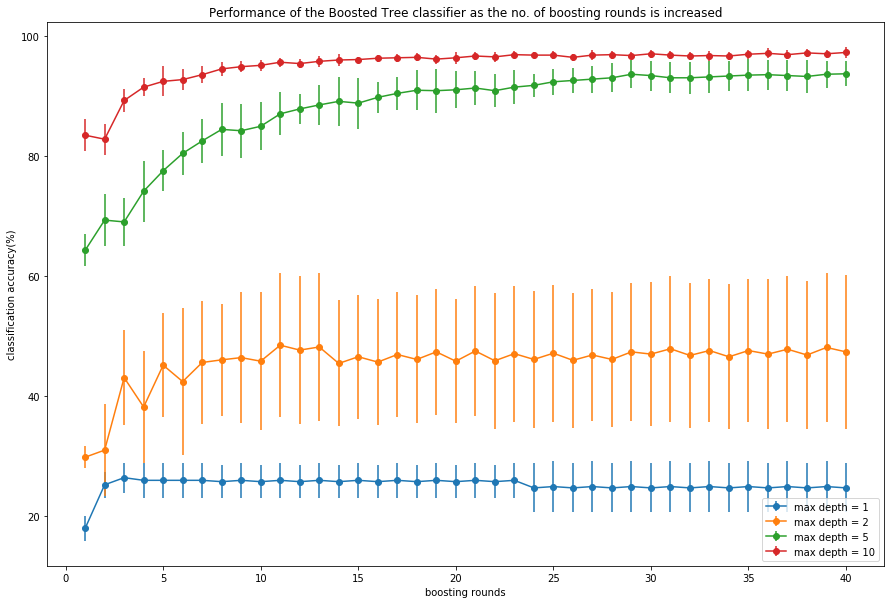

In [13]:
bsvals = np.arange(40) + 1
plt.figure()

out1 = find_err_bsrounds(Xtrain,Ytrain,bsvals,1,5)
errorbar(x = bsvals, y = out1[0,:], yerr = out1[1,:], label = 'max depth = 1', fmt = '-o')

out2 = find_err_bsrounds(Xtrain,Ytrain,bsvals,2,5)
errorbar(x = bsvals, y = out2[0,:], yerr = out2[1,:], label = 'max depth = 2', fmt = '-o')

out5 = find_err_bsrounds(Xtrain,Ytrain,bsvals,5,5) 
errorbar(x = bsvals, y = out5[0,:], yerr = out5[1,:], label = 'max depth = 5', fmt = '-o')

out10 = find_err_bsrounds(Xtrain,Ytrain,bsvals,10,5)
errorbar(x = bsvals, y = out10[0,:], yerr = out10[1,:], label = 'max depth = 10', fmt = '-o')

plt.title('Performance of the Boosted Tree classifier as the no. of boosting rounds is increased') 
plt.xlabel('boosting rounds')
plt.ylabel('classification accuracy(%)')
plt.legend(loc = 'lower right')

We have used the adaptive boosting classifier to fit our model. We can pick apart many key observations from this plot to understand the Boosting trees classifier:

- Again we see that the higher the max depth the better the performance of the model(classification accuracy) as the use of more layers allows for a better fit of the data.
- Decreased variance for max depth = 5, 10 as the model gets more consistent for higher boosting rounds. Better classifiers are going to be more consistent and resistent to variance. 
- Increased variance for max depth = 1, 2 as the model gets less consistent for higher boosting rounds. Classifiers that perform worse will have a higher variance in accuracy.

<ErrorbarContainer object of 3 artists>

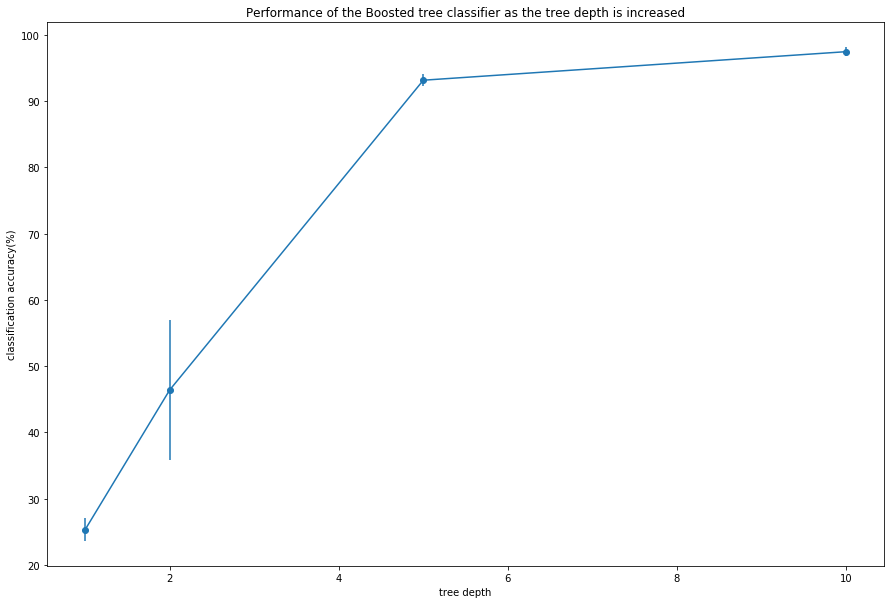

In [14]:
r = np.where(out10[0,:] == np.amax(out10[0,:])) #taking the depth with the best classification accuracy
check = r[0]  #location of maximum score from max_depth=10
bestbs = bsvals[check[0]]

def find_err_abctdepth(Xtrain,Ytrain,tdvals,bestbs,folds): 
    v_err_vec = np.zeros((1,len(tdvals)))  #initialises validation score vector
    v_err_var = np.zeros((1,len(tdvals)))  #initialises standard deviation vector
    for i in np.arange(len(tdvals)):
        abc = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=tdvals[i]), n_estimators=bestbs, random_state = 42) #insert random_state=0 for consistent output 
        kf = KFold(n_splits=folds, shuffle=True, random_state = 26) #sets up the kfold with 'folds' splits
        v_err = np.zeros((folds,1))
        c = 0
        for train, validation in kf.split(Xtrain):
            abc.fit(Xtrain[train], Ytrain[train])  #We fit a classifier based on our training data for each fold
            v_err[c,:] = accuracy_score(abc.predict(Xtrain[validation]),Ytrain[validation]) #validation scores stored for each fold
            c = c + 1  #count
        
        v_err_vec[0,i] = np.sum(100*v_err)  #the total validation score is stored in a vector; with position based on the depth value
        v_err_var[0,i] = np.std(100*v_err)  #standard deviations across kfold for each tree depth value
    
    avv_err = v_err_vec/folds  #turns total score vector into average score vector
    matr = np.stack((avv_err[0,:],v_err_var[0,:]), axis=0) #stacks the vectors to output
    return matr

tdvals = [1,2,5,10]
out = find_err_abctdepth(Xtrain,Ytrain,tdvals,bestbs,5)
plt.figure()
plt.title('Performance of the Boosted tree classifier as the tree depth is increased') 
plt.xlabel('tree depth')
plt.ylabel('classification accuracy(%)')
errorbar(x = tdvals, y = out[0,:], yerr = out[1,:], fmt = '-o')



As with the Random Forests Classifier we observe improved performance for a higher tree depth and find that max tree depths of 5 and 10 perform a lot better than max tree depths of 1 and 2.

We also observe a higher standard deviation the closer the performance of the classifier is to 50% which is also noticable in the previous graph. 

In [15]:
r = np.where(out[0,:] == np.amax(out[0,:])) #taking the depth with the best classification accuracy
check = r[0]  #location of maximum score
bestabctd = tdvals[check[0]]
abc = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=bestabctd), n_estimators=bestbs)
tic()
abc.fit(Xtrain,Ytrain)
abctime = toc()
abctesterr = 100*accuracy_score(abc.predict(Xtest),Ytest)
print("The test score for our adaptive boosting classifier is",abctesterr)

The test score for our adaptive boosting classifier is 98.66666666666667


Finally provide a summary table of the best performance obtained by each algorithm in your experiments (Decision Tree, Random Forest and Boosted Trees), along with the estimated processing time (use the <tt>timeit</tt> package to measure training time). 
<div style="text-align: right"><b>[15 marks]</b></div>

In [16]:
import pandas as pd

df = pd.DataFrame({'Classifier':['Decision Tree', 'Random Forests', 'Boosted Trees'],
                   'Test Classification Accuracy':[dtctesterr, rfctesterr , abctesterr],
                   'Training Time':[dtctime, rfctime, abctime]})

print(df)

       Classifier  Test Classification Accuracy  Training Time
0   Decision Tree                     82.444444       0.023511
1  Random Forests                     96.000000       0.335388
2   Boosted Trees                     98.666667       0.895068


The Decision Tree classifier produces the lowest test classification accuracy.

Random forests classifiers mitigate a few of the problems that occur within the decision tree classifier. Such as error due to variance by averaging over many trees. This produces a much improved test classification accuracy.

Boosted Trees is generally very slightly better as the weighting system is able to punish bad classifiers massively allowing for a better final model. This means better trees with a higher weight will have more influence on the final classification.

In terms of time:

Boosted Trees are the slowest because they cannot be run simultaneously and must be run in sequence in order to reweight misclassified samples at each round. Also calculation of weights and classifier weights will add to the fitting time.

Random Forests are faster as each tree within the forest can be run simultaneously (or at least as many cores as you have).

Decision Tree is a single tree so it'll automatically run for a fraction of the random forests time.

